In [1]:
%load_ext tikzmagic
%matplotlib inline

# 가중치 검정

앞 절에서 선형회귀분석을 사용하여 계산한 가중치의 추정값 $\hat{w}$은 자연법칙에서 정해진 정확한 가중치 $w$와 다를 수 있다고 하였다. 팁 데이터를 사용하여 이 사실을 좀 더 자세히 설명한다. 우리는 현재 다음과 같은 244개 레코드의 팁 데이터를 가지고 있다.

In [2]:
import seaborn as sns

tips = sns.load_dataset("tips")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


하지만 이 팁 데이터는 특정한 기간동안 식당에서 수집한 데이터일 것이다. 이 데이터를 수집하기 전에도 데이터는 계속 나오고 있었고 수집과정이 끝난 이후에도 데이터는 계속 생성되어 나올 것이다.
만약 우리가 선형회귀분석으로 구한 가중치가 자연법칙에 의해 정해진 정확한 값이라면 이 데이터 뿐 아니라 다른 시점에 나온 데이터를 쓴다고 하더라고 같은 가중치가 나와야 할 것이다. 
같은 논리로 우리가 가진 244개의 데이터 중 일부만 사용하여 가중치를 계산한다고 하더라고 항상 같은 값이 나와야 한다. 이 사실을 검증하기 위해 244개의 데이터를 122개씩 2개의 데이터셋으로 나누어 각각 가중치를 구해보자.

In [3]:
tips1 = tips.iloc[:122]
tips2 = tips.iloc[122:]

앞부분 절반의 데이터만 사용하여 가중치를 구해보자. 일단 모형 문자열은 앞에서 사용한 것과 같다.

In [4]:
import statsmodels.api as sm

formula = "tip ~ scale(total_bill) + scale(size) + C(sex)"

In [5]:
result1 = sm.OLS.from_formula(formula, tips1).fit()
result1.params

Intercept            3.090691
C(sex)[T.Female]    -0.116007
scale(total_bill)    0.877198
scale(size)          0.061576
dtype: float64

이번에는 뒷부분 절반의 데이터만 사용하여 가중치를 구한 결과이다.

In [6]:
result2 = sm.OLS.from_formula(formula, tips2).fit()
result2.params

Intercept            2.878103
C(sex)[T.Female]     0.164822
scale(total_bill)    0.788890
scale(size)          0.300813
dtype: float64

두 선형회귀분석 결과가 서로 다르다는 것을 알 수 있다. 심지어 sex 데이터의 가중치는 부호조차 서로 다르다. 이 결과를 따르자면 만약 데이터 수집을 더 진행하여 추가적인 데이터를 얻으면 선형회귀분석의 결과가 달라질 수도 있다는 뜻이다. 

두 데이터셋이 수집되는 동안 자연법칙이 변하지 않았다면 결론은 우리가 구한 가중치의 추정값 $\hat{w}$이 자연법칙이 내장하고 있는 정확한 가중치 $w$가 아니라는 뜻이다. 즉 가중치의 추정값은 오차를 가지고 있다. 이러한 오차가 발생하는 근본적인 원인은 우리가 가진 데이터가 제한적이기 때문이다. 

## 부트스트래핑을 사용한 가중치 추정값의 범위 계산

그러면 가중치 추정값이 가지는 오차의 크기가 어느 정도인지 알 수 있는 방법은 없을까? 정확한 오차를 계산하기 위해서는 뒤에서 설명할 몇가지 가정이 필요하지만 일단 부트스프래핑(boot-straping)이라는 간단한 방법으로 오차의 크기를 짐작해 볼 수 있다.  

<b>부트스프래핑(boot-straping)</b>은 전체 데이터에서 일부 데이터만 무작위로 골라서 선형회귀분석을 하는 것을 반복하는 것이다. 한번 무작위 선택 후 선형회귀분석을 실시하면 하나의 가중치 추정값 세트가 나온다. 또 한번 다시 데이터를 무작위 선택하여 선형회귀분석을 실시하면 또다른 가중치 추정값 세트가 나온다. 이 과정을 1000번 반복하면 1000개의 가중치 추정값 세트가 나오게 된다. 이렇게 나온 1000개의 가중치 추정값의 분포를 살펴보면 대략적으로 가중치 추정값이 어떤 범위에 있는지 살펴볼 수 있다.

다음 코드는 1000번의 반복 부트스트래핑을 통해 1000개의 가중치 추정값 세트를 구하는 코드다. 1000번의 선형회귀분석을 반복해야해서 실행시간이 길다. 코드 앞부분의 `%%time`은 코드의 실행시간을 출력하는 주피터 노트북 매직명령이다. 저자의 컴퓨터에서는 10초 이상의 시간이 걸렸다.

In [7]:
%%time

import numpy as np
import pandas as pd

np.random.seed(0)
N = 1000
params_w0 = np.zeros(N)
params_w1 = np.zeros(N)
params_w2 = np.zeros(N)
params_w3 = np.zeros(N)
for i in range(N):
    idx = np.random.choice(len(tips), len(tips), replace=True)
    tips_i = tips.iloc[idx]
    result = sm.OLS.from_formula(formula, tips_i).fit()
    params_w0[i] = result.params.iloc[0]
    params_w1[i] = result.params.iloc[1]
    params_w2[i] = result.params.iloc[2]
    params_w3[i] = result.params.iloc[3]

weights = pd.DataFrame({
    "w_0": params_w0,
    "w_sex": params_w1,
    "w_total_bill": params_w2,
    "w_size": params_w3,
})
weights

CPU times: total: 15.3 s
Wall time: 15.3 s


,w_0,w_sex,w_total_bill,w_size
0,2.932750,0.005990,0.718988,0.227791
1,3.084244,0.087494,0.995008,0.049014
2,2.839063,0.034984,0.634239,0.285801
3,2.978962,0.032246,0.655065,0.034758
4,2.888683,0.075727,0.799001,0.162599
...,...,...,...,...
995,2.863593,0.023681,0.767523,0.253856
996,2.826096,0.268302,0.683563,0.227148
997,2.945665,0.049849,1.045534,0.047011
998,2.992950,0.013680,0.751426,0.206695


이 결과를 히스토그램으로 나타내면 다음과 같다.

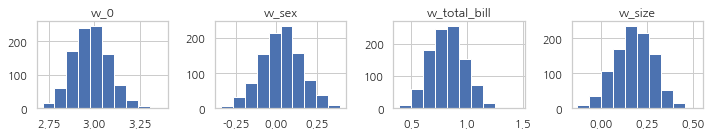

In [8]:
weights.hist(figsize=(10, 2), layout=(1, 4))
plt.tight_layout()
plt.show()

이 가중치 추정값들의 간단한 통계는 다음과 같다.

In [9]:
weights.describe()

,w_0,w_sex,w_total_bill,w_size
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.982061,0.032277,0.824139,0.178676
std,0.099503,0.124839,0.151586,0.104542
min,2.714403,-0.342809,0.391266,-0.127939
25%,2.912348,-0.052066,0.711447,0.103797
50%,2.979314,0.033755,0.821183,0.179384
75%,3.048256,0.113475,0.924565,0.252902
max,3.372273,0.395771,1.461748,0.523164


우선 각 가중치의 평균값은 244개의 모든 데이터를 사용하여 구한 가중치 추정값과 비슷하다.

In [10]:
result = sm.OLS.from_formula(formula, tips).fit()
result.params

Intercept            2.988859
C(sex)[T.Female]     0.026419
scale(total_bill)    0.825518
scale(size)          0.182794
dtype: float64

다음으로 각 가중치의 범위를 살펴본다. total_bill 변수의 가중치의 약 0.8이고 표준편차는 이보다 작은 0.15다. 값의 범위는 0.4~1.5 정도로 음수가 나오는 경우는 없다. 즉 total_bill 값이 커질수록 팁이 증가하는 결과는 변함없다. 하지만 sex 변수 가중치의 경우, 평균은 0.03이고 표준편차는 0.12로 표준편차의 크기가 평균보다 크다. 따라서 값의 범위가 -0.3 ~ 0.3로 음수인 경우도 나오고 양수인 경우도 나온다. 이는 sex 변수가 팁에 미치는 영향을 정확히 분석할 수 없다는 뜻이다. 극단적으로는 sex 변수 가중치의 진실된 값은 0인데 오차로 인해 0이 아닌 숫자가 나온 것일 수도 있다. 

가중치의 값이 0이라는 것은 해당 독립변수가 종속변수에 전혀 영향을 미치지 않는다는 뜻이다. 즉, 선형회귀분석을 할 때 독립변수로 넣으면 안된다는 의미가 된다.

## 확률론적 가정을 사용한 가중치 표준편차 계산

부트스트래핑을 사용하여 가중치 추정값의 범위 즉, 표준편차를 대략이나마 계산할 수 있었다. 하지만 부트스트래핑은 선형회귀분석을 반복해야하므로 실행시간이 오래 걸린다는 단점이 있다. 몇가지 확률론적 가정을 한다면 부트스트래핑을 하지 않고도 가중치 추정값의 표준편차를 빠르게 계산할 수 있는 방법이 있다. 사용하는 가정은 다음과 같다.

1. 교란항 $\varepsilon$은 기댓값이 0이고 분산값이 어떤 경우에도 변하지 않는 정규분포다.
1. 교란항 $\varepsilon$의 값은 독립변수들의 값에 영향을 받지 않는다.
1. 교란항 $\varepsilon$의 값은 서로 영향을 주지 않는다.

이러한 가정하에서 가중치 $w_j$의 표준편차 $se_j$는 다음 수식으로 계산할 수 있다. se는 standard error의 약자이다.

$$
se_j = \sqrt{\dfrac{e^Te}{N-K} \big((X^TX)^{-1}\big)_{jj}}
$$

이 수식에서 $e$는 잔차 벡터이고 $(X^TX)^{-1}\big)_{jj}$는 행렬 $(X^TX)^{-1}$의 $j$번째 대각성분을 뜻한다.

statsmodels 패키지를 사용한 선형회귀분석 결과 객체는 `bse` 속성에 가중치 표준편차 정보를 미리 계산하여 가지고 있다. 

In [11]:
result.bse

Intercept            0.081358
C(sex)[T.Female]     0.137179
scale(total_bill)    0.081698
scale(size)          0.081138
dtype: float64

결과 객체의 `summary` 메서드로 나오는 결과요약에도 이 정보가 포함되어 있다. 

In [12]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    tip   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     70.36
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           1.11e-32
Time:                        17:31:44   Log-Likelihood:                -347.97
No. Observations:                 244   AIC:                             703.9
Df Residuals:                     240   BIC:                             717.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.9889      0.08

결과요약에서 `std err`로 표시된 다음 부분이 위 식으로 계산한 표준편차다.

```
============================================
                                std err     
--------------------------------------------
Intercept                         0.081     
C(sex)[T.Female]                  0.137     
scale(total_bill)                 0.082     
scale(size)                       0.081     
```

## 가중치 검정

확률론적 가정을 했을 때 얻을 수 있는 또다른 결론은 표준편차로 나눈 가중치 추정값 $\hat{w}$가 진실된 가중치 $w$를 중심으로 하고 자유도가 $N−K-1$인 스튜던트t분포를 따른다는 점이다. 여기서 $N$은 데이터의 개수, $K$는 독립변수의 개수다.

$$
\dfrac{\hat{w}_i - w_i}{se_i} \sim t_{N-K-1}
$$

이 사실을 사용하면 진실된 가중치 $w$가 존재할 범위를 계산할 수 있다. statsmodels 패키지로 구한 선형회귀분석 결과 요약에서 `[0.025`라는 열에 표시된 값은 가중치 추정값이 이 값보다 작을 확률이 2.5%라는 뜻이고 `0.975]`라는 열에 표시된 값은 가중치 추정값이 이 값보다 클 확률이 2.5%라는 뜻이다. 즉, 진실된 가중치는 95%의 확률로 이 두 값 사이에 존재한다.

```
=====================================================================================
                                                                  [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept                                                          2.829       3.149
C(sex)[T.Female]                                                  -0.244       0.297
scale(total_bill)                                                  0.665       0.986
scale(size)                                                        0.023       0.343
```

예를 들어 total_bill에 대한 가중치의 추정값은 0.8255이지만 진실된 가중치는 0.665 ~ 0.986 사이에 95%의 확률로 존재한다.